# Install library

In [10]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Dataset preprocessing and EDA

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 1)
(10000, 3072)
(10000, 1)


In [13]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [14]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [15]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [16]:
print(x_train_removed.shape)
print(y_train_removed.shape)

(42500, 3072)
(42500, 1)


In [17]:
df = pd.DataFrame(y_train_removed.flatten())
df.value_counts()

0    5000
1    5000
3    5000
5    5000
6    5000
7    5000
8    5000
2    2500
4    2500
9    2500
dtype: int64

(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

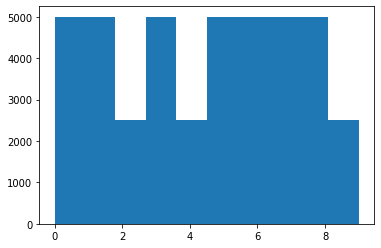

In [18]:
import matplotlib.pyplot as plt

# データ数をプロット
plt.hist(y_train_removed.flatten())

## AutoEncoder

In [30]:
# For autoencode ver2
encoding_dim = 32  # 32 dimention
# input_img = Input(shape=(3072,), name="Input_AE") # 32 * 32 * 3
# encoded = Dense(encoding_dim, activation='relu', name="Dense_AE_0")(input_img)
# decoded = Dense(3072, activation='sigmoid', name="Dense_AE_1")(encoded) # 32 * 32 * 3
# autoencoder = Model(input_img, decoded)

# 中間層を 4 層まで増やしたネットワーク
autoencoder = models.Sequential()
autoencoder.add(layers.Dense(128, activation='relu',
                       input_shape=(3072,), name="Dense_AE_0"))
autoencoder.add(layers.Dense(64, activation='relu', name="Dense_AE_1"))
autoencoder.add(layers.Dense(encoding_dim, activation='relu', name="Dense_AE_2"))
autoencoder.add(layers.Dense(64, activation='relu', name="Dense_AE_3"))
autoencoder.add(layers.Dense(128, activation='relu', name="Dense_AE_4"))
autoencoder.add(layers.Dense(3072,
                       activation='sigmoid', name="Dense_AE_5"))

In [31]:
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_AE_0 (Dense)           (None, 128)               393344    
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 64)                8256      
_________________________________________________________________
Dense_AE_2 (Dense)           (None, 32)                2080      
_________________________________________________________________
Dense_AE_3 (Dense)           (None, 64)                2112      
_________________________________________________________________
Dense_AE_4 (Dense)           (None, 128)               8320      
_________________________________________________________________
Dense_AE_5 (Dense)           (None, 3072)              396288    
Total params: 810,400
Trainable params: 810,400
Non-trainable params: 0
________________________________________________

In [32]:
# hyperparameters
batch_size = 32
epochs = 50

# train
saveDir = "../models/AE/"

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = saveDir + 'AE_Cifar10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
chkpt = saveDir + 'AE_Cifar10_002_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

AE_history = autoencoder.fit(x_train_removed, x_train_removed,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, x_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/50
1325/1329 [============================>.] - ETA: 0s - loss: 0.6142
Epoch 00001: val_loss improved from inf to 0.60026, saving model to ../models/AE\AE_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 5s 4ms/step - loss: 0.6142 - val_loss: 0.6003
Epoch 2/50
1320/1329 [============================>.] - ETA: 0s - loss: 0.5964
Epoch 00002: val_loss improved from 0.60026 to 0.59697, saving model to ../models/AE\AE_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 5s 4ms/step - loss: 0.5964 - val_loss: 0.5970
Epoch 3/50
1320/1329 [============================>.] - ETA: 0s - loss: 0.5922
Epoch 00003: val_loss improved from 0.59697 to 0.59322, saving model to ../models/AE\AE_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 6s 4ms/step - loss: 0.5922 - val_loss: 0.5932
Epoch 4/50
1321/1329 [============================>.] - ETA: 0s - loss: 0.5894- E
Epoch 00004: val_loss improved from 0.59322 to 0.59151, saving model to ../models/

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

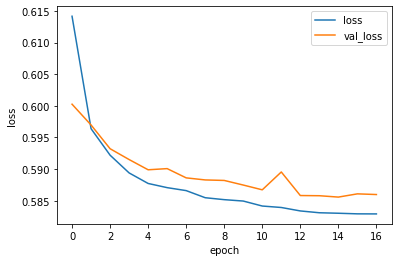

In [33]:
# plot training
AE_hist_df = pd.DataFrame(AE_history.history)

plt.figure()
AE_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [36]:
autoencoder.load_weights("../models/AE/AE_Cifar10_002_Best.hdf5")
# autoencoder.trainable = False
# For encode
# layer_name_0 = 'Dense_AE_0'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('Dense_AE_2').output)

In [148]:
autoencoder.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_AE (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
Dense_AE_0 (Dense)           (None, 32)                98336     
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 3072)              101376    
Total params: 199,712
Trainable params: 0
Non-trainable params: 199,712
_________________________________________________________________


In [46]:
# Encode and decode some digits
decoded_imgs = autoencoder.predict(x_test)

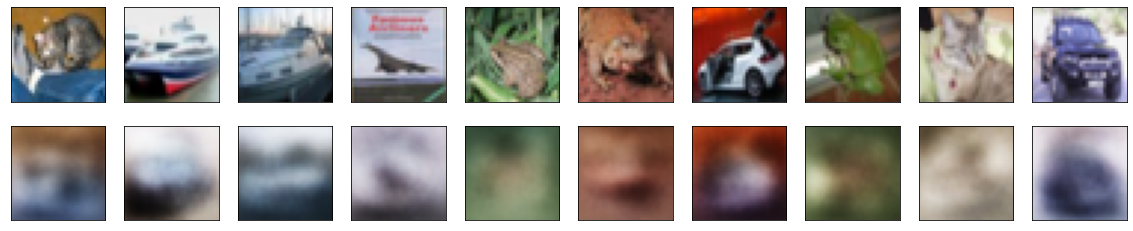

In [47]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Classification Model

In [37]:
autoencoder.trainable = False

In [38]:
encoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_AE_0_input (InputLayer [(None, 3072)]            0         
_________________________________________________________________
Dense_AE_0 (Dense)           (None, 128)               393344    
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 64)                8256      
_________________________________________________________________
Dense_AE_2 (Dense)           (None, 32)                2080      
Total params: 403,680
Trainable params: 0
Non-trainable params: 403,680
_________________________________________________________________


In [39]:
model = Sequential()

model.add(encoder)
model.add(Dense(10, activation='softmax',name="Dense_0",input_shape=(32,)))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 32)                403680    
_________________________________________________________________
Dense_0 (Dense)              (None, 10)                330       
Total params: 404,010
Trainable params: 330
Non-trainable params: 403,680
_________________________________________________________________


In [41]:
from tensorflow.keras.utils import plot_model, to_categorical

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = saveDir + 'Affine_Cifar10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
chkpt = saveDir + 'Affine_Cifar10_002_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


Affine_history = model.fit(x_train_removed, y_train_removed_onehot,
                    batch_size=32,
                    epochs=400,
                    verbose=1,
                    validation_data=(x_test, y_test_onehot),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/400
1282/1329 [===========================>..] - ETA: 0s - loss: 3.5714 - accuracy: 0.1023
Epoch 00001: val_loss improved from inf to 2.84471, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 944us/step - loss: 3.5455 - accuracy: 0.1025 - val_loss: 2.8447 - val_accuracy: 0.1051
Epoch 2/400
1291/1329 [============================>.] - ETA: 0s - loss: 2.7282 - accuracy: 0.1227 ETA: 0s - loss: 2.7542 - ac
Epoch 00002: val_loss improved from 2.84471 to 2.70684, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 883us/step - loss: 2.7261 - accuracy: 0.1234 - val_loss: 2.7068 - val_accuracy: 0.1194
Epoch 3/400
1274/1329 [===========================>..] - ETA: 0s - loss: 2.5867 - accuracy: 0.1369
Epoch 00003: val_loss improved from 2.70684 to 2.57681, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 883us/step - los

Epoch 25/400
1291/1329 [============================>.] - ETA: 0s - loss: 1.8594 - accuracy: 0.3510 ETA: 0s - loss: 1.8637 - ac
Epoch 00025: val_loss improved from 1.94984 to 1.93739, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 874us/step - loss: 1.8592 - accuracy: 0.3510 - val_loss: 1.9374 - val_accuracy: 0.3163
Epoch 26/400
1296/1329 [============================>.] - ETA: 0s - loss: 1.8546 - accuracy: 0.3535
Epoch 00026: val_loss did not improve from 1.93739
1329/1329 [==============================] - 1s 858us/step - loss: 1.8544 - accuracy: 0.3538 - val_loss: 1.9433 - val_accuracy: 0.3142
Epoch 27/400
1289/1329 [============================>.] - ETA: 0s - loss: 1.8511 - accuracy: 0.3541
Epoch 00027: val_loss did not improve from 1.93739
1329/1329 [==============================] - 1s 862us/step - loss: 1.8500 - accuracy: 0.3548 - val_loss: 1.9388 - val_accuracy: 0.3144
Epoch 00027: early stopping


## Result

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

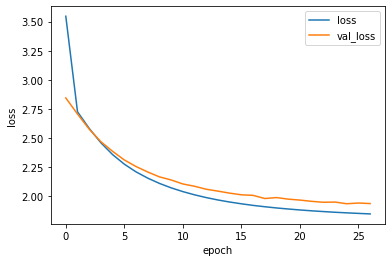

<Figure size 432x288 with 0 Axes>

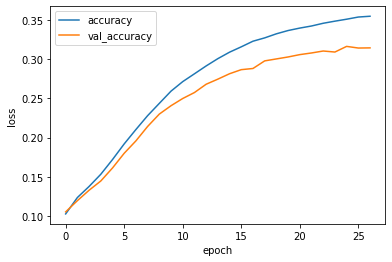

In [42]:
# plot training
Affine_hist_df = pd.DataFrame(Affine_history.history)

plt.figure()
Affine_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
Affine_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [43]:
# load best model
model.load_weights("../models/CNN/Affine_Cifar10_002_Best.hdf5")

In [44]:
model.evaluate(x_test , y_test_onehot)

313/313 [==============================] - 0s 655us/step - loss: 1.9374 - accuracy: 0.3163


[1.937394380569458, 0.31630000472068787]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion matrix, without normalization


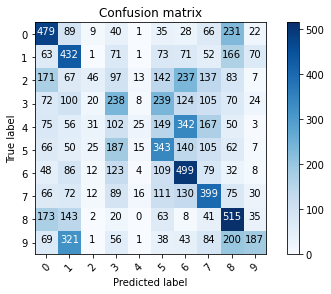

In [45]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predict_classes = model.predict_classes(x_test)
true_classes = y_test
confusion_mtx = confusion_matrix(true_classes, predict_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 